In [48]:
import numpy as np

In [49]:
class antonForest():

    def __init__(self, t_trees, sample_size, random_state) -> None:
        self.t_trees = t_trees
        self.sample_size = sample_size
        self.random_state = random_state

    def fit(self, X):
        
        self.forest = []
        height_limit = np.ceil(np.log2(self.sample_size))
        
        n_rows = X.shape[0]
        for i in range(self.t_trees):
            
            #if n_rows < self.sample_size:
             #   self.sample_size = n_rows
            #index = self.random_state.choice(range(n_rows), size = self.sample_size, replace = False)
            #This row makes the subsampling and split values random for each run
            index = self.random_state.randint(0, n_rows, self.sample_size)
            #index = np.random.choice(range(n_rows), size=self.sample_size, replace=False)
            #index = np.random.randint(0, n_rows, self.sample_size)
            
            sub_X = X[index]
            
            tree = iTree(0, height_limit)
            tree.fit(sub_X)
            self.forest.append(tree)
            
        return self

    def path_length(self, data):

        edges = []

        for row in data:
            path = []
            for tree in self.forest:
                node = tree.root
                length = 0
                while isinstance(node, DecisionNode):
                    if row[node.q_value] < node.x_value:
                        node = node.left
                    else:
                        node = node.right
                    length += 1
                
                leaf_size = node.size
                path_length = length + c(leaf_size)
                path.append(path_length)
            
            edges.append(path)
        edges = np.array(edges)
        return np.mean(edges, axis = -1)

    def decision_function(self, data):

        average_length = self.path_length(data)
        scores = np.array([np.power(2, -l/c(self.sample_size)) for l in average_length])
        #WARNING fix - and +0.5
        scores = -scores + 0.4775
        return scores

    def predict_from_score(self, scores, threshold):
        return np.array([1 if s >= threshold else 0 for s in scores])

    def predict(self, data, threshold):
        scores = self.decision_function(data)
        prediction = self.predict_from_score(scores, threshold)
        return prediction

In [50]:
class Leaf:

    def __init__(self, size, data) -> None:
        self.size = size
        self.data = data

In [51]:
class DecisionNode:

    def __init__(self, left, right, q_value, x_value) -> None:
        self.left = left
        self.right = right
        self.q_value = q_value
        self.x_value = x_value

In [52]:
class iTree():

    def __init__(self, current_height, height_limit) -> None:
        self.current_height = current_height
        self.heigh_limit = height_limit

    def fit(self, sub_sample):
        
        X = sub_sample
        
        if self.current_height >= self.heigh_limit or X.shape[0] <= 2:
            self.root = Leaf(X.shape[0], X)
            return self.root
        else:
            #Chosing random q value
            n_attributes = X.shape[1]#WARNING changed from 1 to 0
            q_value = np.random.randint(0, n_attributes)
            #Chosing random x value
            x_value = np.random.uniform(min(X[:, q_value]), max(X[:, q_value]))

            X_left = X[X[:, q_value] < x_value]
            X_right = X[X[:, q_value] >= x_value]

            left_subtree = iTree(self.current_height + 1, self.heigh_limit)
            right_subtree = iTree(self.current_height + 1, self.heigh_limit)

            left_subtree.fit(X_left)
            right_subtree.fit(X_right)

            self.root = DecisionNode(left_subtree.root, right_subtree.root, q_value, x_value)
            self.n_nodes = self.count_nodes(self.root)

            return self.root

    def count_nodes(self, root):
            
        count = 0
        stack = [root]
           
        while stack:
            node = stack.pop()
            count += 1

        if isinstance(node, DecisionNode):
            stack.append(node.right)
            stack.append(node.left)

        return count


Code for testing and running the classes and functions:

In [53]:
from __future__ import division
from __future__ import print_function
from sklearn.ensemble import IsolationForest

import os
import sys
from time import time

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

from numpy import percentile
from sklearn.metrics import average_precision_score
import scipy.io
import matplotlib.pyplot as plt

In [54]:
# Define the number of inliers and outliers
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0]

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

In [55]:
random_state = np.random.RandomState(42)

In [61]:
# Fit the models with the generated data and 
# compare model performances
def c(size):
    if size > 2:
        return 2 * (np.log(size-1)+0.5772156649) - 2*(size-1)/size
    if size == 2:
        return 1
    return 0

np.random.seed(42)
clf = antonForest(10, 256, random_state=random_state)
clf_lib = IsolationForest(n_estimators = 10, random_state=random_state)
# Data generation
#X1 = 0.3 * np.random.randn(n_inliers // 2, 2) #Removed offest
#X2 = 0.3 * np.random.randn(n_inliers // 2, 2) #Removed offset
#X = np.r_[X1, X2]
# Add outliers
#X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

data = scipy.io.loadmat('C:\\Users\\anton\\OneDrive\\Skrivbord\\Thesis_Code\\IsolationForestTinyML\\DatSets\\wine_m.mat',
                        squeeze_me=False)

enlist = list(data.items())
X = np.array(enlist, dtype=object)
X = np.delete(X, 0, 0)
X = np.delete(X, 0, 0)
X = np.delete(X, 0, 0)
X = np.delete(X, 0, 1)

y_true = np.empty([1,0], dtype=int)

#print(X[1][0][0])
k = 0
#while k < len(X[1][0]):
#    y_true = np.append(y_true, int(X[1][0][k]))
#    k += 1

X = X[0][0]
#print(X[0][0])
# Fit the model
#plt.figure(figsize=(15, 12))
# fit the data and tag outliers
p = 0
aps = []
aps_lib = []
outliers = 10
#while p < 10:
clf.fit(X)
clf_lib.fit(X)
#WARNING put +1
scores_pred = clf.decision_function(X) * 1

scores_pred_lib = clf_lib.decision_function(X) * 1 

threshold = percentile(scores_pred, 100 * outliers_fraction)
threshold_lib = percentile(scores_pred_lib, 100 * outliers_fraction)



#aps.append(average_precision_score(y_true, scores_pred))
#aps_lib.append(average_precision_score(y_true, scores_pred_lib))
#p += 1
#n_errors = (y_pred != ground_truth).sum()
# plot the levels lines and the points

#WARNING +1
#Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * 1
#Z = Z.reshape(xx.shape)
#plt.figure(figsize=[10,10])
#subplot = plt.subplot(2, 2, 1)
#subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
#                    cmap=plt.cm.Blues_r)
#a = subplot.contour(xx, yy, Z, levels=[threshold], #Removed - in front of threshold, since -score
#                    linewidths=2, colors='red')
#subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
#                    colors='orange')
#b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
#                    s=20, edgecolor='k')
#c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
#                    s=20, edgecolor='k')
#subplot.axis('tight')
#subplot.set_xlabel("%d. %s (errors: %d)" % (1, "Isolation Forest", n_errors))
#subplot.set_xlim((-7, 7))
#subplot.set_ylim((-7, 7))
#plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
#plt.suptitle("Outlier detection")
#plt.show()
#all_data = [aps, aps_lib]
#plt.boxplot(all_data)
#print(scores_pred)
#print(scores_pred_lib)

In [42]:
print(scores_pred)


[ 0.02569222  0.010808    0.03396616 -0.02181594 -0.0098167   0.00632807
 -0.02179669  0.02893669 -0.06030643  0.00146701 -0.08235951 -0.00190268
 -0.01545247  0.02882687  0.02034501 -0.03794916  0.01224532 -0.04847348
 -0.00440098 -0.02444818 -0.02036464  0.03212202 -0.04751796  0.02653548
 -0.04373386 -0.04404791 -0.01446269 -0.01250075  0.03707242 -0.01308998
 -0.016096   -0.01944764  0.02853292  0.03269771  0.02513621 -0.02713098
  0.04237885  0.05205044  0.02372111  0.03735375 -0.01745083  0.0301926
  0.0180692   0.01060138  0.00892724  0.01948099 -0.01025029 -0.07759271
  0.05797891 -0.08669024 -0.0063251   0.05291097  0.04609857  0.03969415
  0.00678986  0.02605525 -0.04162535  0.04790145  0.03341549  0.03262885
 -0.02110878 -0.06498584  0.02332692 -0.00686776 -0.02660976  0.03338161
 -0.05718786  0.03888288  0.054755   -0.07135293 -0.00585337  0.0044129
 -0.22393204  0.02634674 -0.02391256 -0.06363009  0.02264075  0.03212937
  0.01011472  0.04429554  0.04688834 -0.03207686  0.0

In [43]:
print(scores_pred_lib)

[-0.01633231 -0.02857439  0.04980094 -0.04821929 -0.02943134  0.04956299
 -0.05827993  0.06408442 -0.06265772 -0.00358234 -0.00654446  0.07680852
  0.12864022  0.09041365  0.04002984  0.09676026  0.09291589  0.00195041
  0.07105675  0.04137653 -0.06312841  0.03949456  0.02639943  0.07942418
 -0.07984263 -0.00279086  0.07771987  0.0614333   0.02807094  0.00579803
  0.08384498  0.07671093  0.09957244  0.12153628  0.08910583  0.01572327
  0.10421951  0.13487544  0.02682428  0.08165925  0.08222715  0.13806415
  0.13317334  0.12483325  0.07092056  0.05560812 -0.03311957  0.00133422
  0.10670751 -0.03579311  0.02945126  0.05138732  0.10931382  0.06868852
  0.06165665  0.06820158  0.07000007  0.12735655  0.13547736  0.11338062
 -0.0239752  -0.05872295  0.12050402  0.03353048  0.06987468  0.09345505
 -0.10966879  0.07244848  0.11960101  0.13300308  0.06672668  0.05064277
 -0.16696819  0.01355721  0.06550617 -0.05872295  0.10553299  0.08969646
 -0.01116539  0.10158527  0.12892905  0.07999946  0

In [45]:
file = open("save_vectors.ino", "w")

file.write("#include <vector>\n")
file.write("using namespace std;\n\n")
file.write("struct Tree{\n")
file.write("    int child_id_left, child_id_right, feature, n_samples;\n")
file.write("    float threshold;\n")
file.write("};\n\n")

file.write("vector<vector<Tree>> iForest;\n")
m = 0
while m < clf_lib.n_estimators:
    file.write("std::vector<Tree> iTree" + str(m + 1) + ";\n")
    m += 1
file.write("\n")

f = 0
file.write("void setup() {\n")
file.write("    Serial.begin(9600);\n")
while f < clf_lib.n_estimators:
    j = 0
    while j < len(clf_lib.estimators_[f].tree_.feature):
        temp_child_l = clf_lib.estimators_[f].tree_.children_left[j]
        if clf_lib.estimators_[f].tree_.children_left[j] == -1:
            temp_child_l = 0

        temp_child_r = clf_lib.estimators_[f].tree_.children_right[j]
        if temp_child_r == clf_lib.estimators_[f].tree_.children_right[j] == -1:
            temp_child_r = 0

        temp_feature = clf_lib.estimators_[f].tree_.feature[j]
        temp_threshold = clf_lib.estimators_[f].tree_.threshold[j]
        temps_values = clf_lib.estimators_[f].tree_.n_node_samples[j]

        file.write("    iTree" + str(f + 1) + ".push_back({"  
                                                            + str(temp_child_l) + ", "
                                                            + str(temp_child_r) + ", "
                                                            + str(temp_feature) + ", "
                                                            + str(temps_values) + ", "
                                                            + str(temp_threshold) + 
                                                        "});\n")

        j += 1

    file.write("    iForest.push_back(iTree" + str(f + 1) + ");\n\n")
    f += 1

rows = f*j
memory_per_vector = 8
allocated_memory = rows * memory_per_vector
file.write("}\n")
file.write("void loop() {\n")
file.write("\n}")




2

<Figure size 1080x864 with 0 Axes>

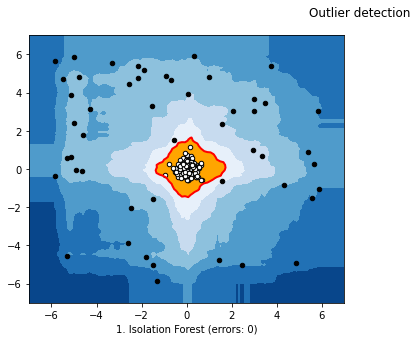

In [30]:
# Fit the models with the generated data and 
# compare model performances
def c(size):
    if size > 2:
        return 2 * (np.log(size-1)+0.5772156649) - 2*(size-1)/size
    if size == 2:
        return 1
    return 0

np.random.seed(42)
clf = antonForest(100, 256, random_state=random_state)
clf_lib = IsolationForest(random_state=random_state)
# Data generation
X1 = 0.3 * np.random.randn(n_inliers // 2, 2) #Removed offest
X2 = 0.3 * np.random.randn(n_inliers // 2, 2) #Removed offset
X = np.r_[X1, X2]
# Add outliers
X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]


# Fit the model
plt.figure(figsize=(15, 12))
# fit the data and tag outliers
clf.fit(X)
clf_lib.fit(X)
#WARNING put +1
scores_pred = clf.decision_function(X) * 1
scores_pred_lib = clf_lib.decision_function(X) * 1 

threshold = percentile(scores_pred, 100 * outliers_fraction)
threshold_lib = percentile(scores_pred_lib, 100 * outliers_fraction)

y_pred = clf.predict(X, threshold) * -1
y_pred = (y_pred + 1) #/ 2

y_pred_lib = clf_lib.predict(X) * -1
y_pred_lib = (y_pred_lib + 1) / 2

n_errors = (y_pred != ground_truth).sum()
# plot the levels lines and the points

#WARNING +1
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * 1
Z = Z.reshape(xx.shape)
plt.figure(figsize=[10,10])
subplot = plt.subplot(2, 2, 1)
subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                    cmap=plt.cm.Blues_r)
a = subplot.contour(xx, yy, Z, levels=[threshold], #Removed - in front of threshold, since -score
                    linewidths=2, colors='red')
subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                    colors='orange')
b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                    s=20, edgecolor='k')
c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                    s=20, edgecolor='k')
subplot.axis('tight')
subplot.set_xlabel("%d. %s (errors: %d)" % (1, "Isolation Forest", n_errors))
subplot.set_xlim((-7, 7))
subplot.set_ylim((-7, 7))
plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
plt.suptitle("Outlier detection")
plt.show()